In [28]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [29]:
import os
import time
import shutil
import pathlib
import itertools

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [30]:
data_dir = '/kaggle/input/mango-leaf-disease/test'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

In [31]:
df

,filepaths,labels
0,/kaggle/input/mango-leaf-disease/test/Powdery ...,Powdery Mildew
1,/kaggle/input/mango-leaf-disease/test/Powdery ...,Powdery Mildew
2,/kaggle/input/mango-leaf-disease/test/Powdery ...,Powdery Mildew
3,/kaggle/input/mango-leaf-disease/test/Powdery ...,Powdery Mildew
4,/kaggle/input/mango-leaf-disease/test/Powdery ...,Powdery Mildew
...,...,...
795,/kaggle/input/mango-leaf-disease/test/Die Back...,Die Back
796,/kaggle/input/mango-leaf-disease/test/Die Back...,Die Back
797,/kaggle/input/mango-leaf-disease/test/Die Back...,Die Back
798,/kaggle/input/mango-leaf-disease/test/Die Back...,Die Back


In [32]:
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123)

# valid and test dataframe
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.6, shuffle= True, random_state= 123)

In [33]:
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Recommended : use custom function for test data batch size, else we can use normal batch size.
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

# This function which will be used in image data generator for data augmentation, it just take the image and return it again.
def scalar(img):
    return img

tr_gen = ImageDataGenerator(preprocessing_function= scalar)
ts_gen = ImageDataGenerator(preprocessing_function= scalar)

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

# Note: we will use custom test_batch_size, and make shuffle= false
test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= test_batch_size)

Found 640 validated image filenames belonging to 8 classes.
Found 96 validated image filenames belonging to 8 classes.
Found 64 validated image filenames belonging to 8 classes.


In [34]:
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use efficientnetb3 from EfficientNet family.
base_model = tf.keras.applications.ResNet50(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation=None
)

base_model.trainable = False

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 1000)              25636712  
                                                                 
 batch_normalization_3 (Batc  (None, 1000)             4000      
 hNormalization)                                                 
                                                                 
 dense_6 (Dense)             (None, 256)               256256    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 8)                 2056      
                                                                 
Total params: 25,899,024
Trainable params: 260,312
Non-trainable params: 25,638,712
____________________________________

In [35]:
batch_size = 16   # set batch size for training
epochs = 10   # number of all epochs in training

history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, validation_steps= None, shuffle= False)

Epoch 1/10
40/40 [==============================] - 9s 110ms/step - loss: 7.9367 - accuracy: 0.7125 - val_loss: 7.4822 - val_accuracy: 0.9271
Epoch 2/10
40/40 [==============================] - 2s 44ms/step - loss: 6.8221 - accuracy: 0.9297 - val_loss: 6.6835 - val_accuracy: 0.9375
Epoch 3/10
40/40 [==============================] - 2s 43ms/step - loss: 6.2826 - accuracy: 0.9422 - val_loss: 6.0708 - val_accuracy: 0.9896
Epoch 4/10
40/40 [==============================] - 2s 44ms/step - loss: 5.8058 - accuracy: 0.9594 - val_loss: 5.5696 - val_accuracy: 0.9896
Epoch 5/10
40/40 [==============================] - 2s 46ms/step - loss: 5.3238 - accuracy: 0.9812 - val_loss: 5.1383 - val_accuracy: 0.9792
Epoch 6/10
40/40 [==============================] - 2s 46ms/step - loss: 4.9448 - accuracy: 0.9766 - val_loss: 4.7475 - val_accuracy: 0.9688
Epoch 7/10
40/40 [==============================] - 2s 44ms/step - loss: 4.5396 - accuracy: 0.9953 - val_loss: 4.3886 - val_accuracy: 0.9583
Epoch 8/10
4

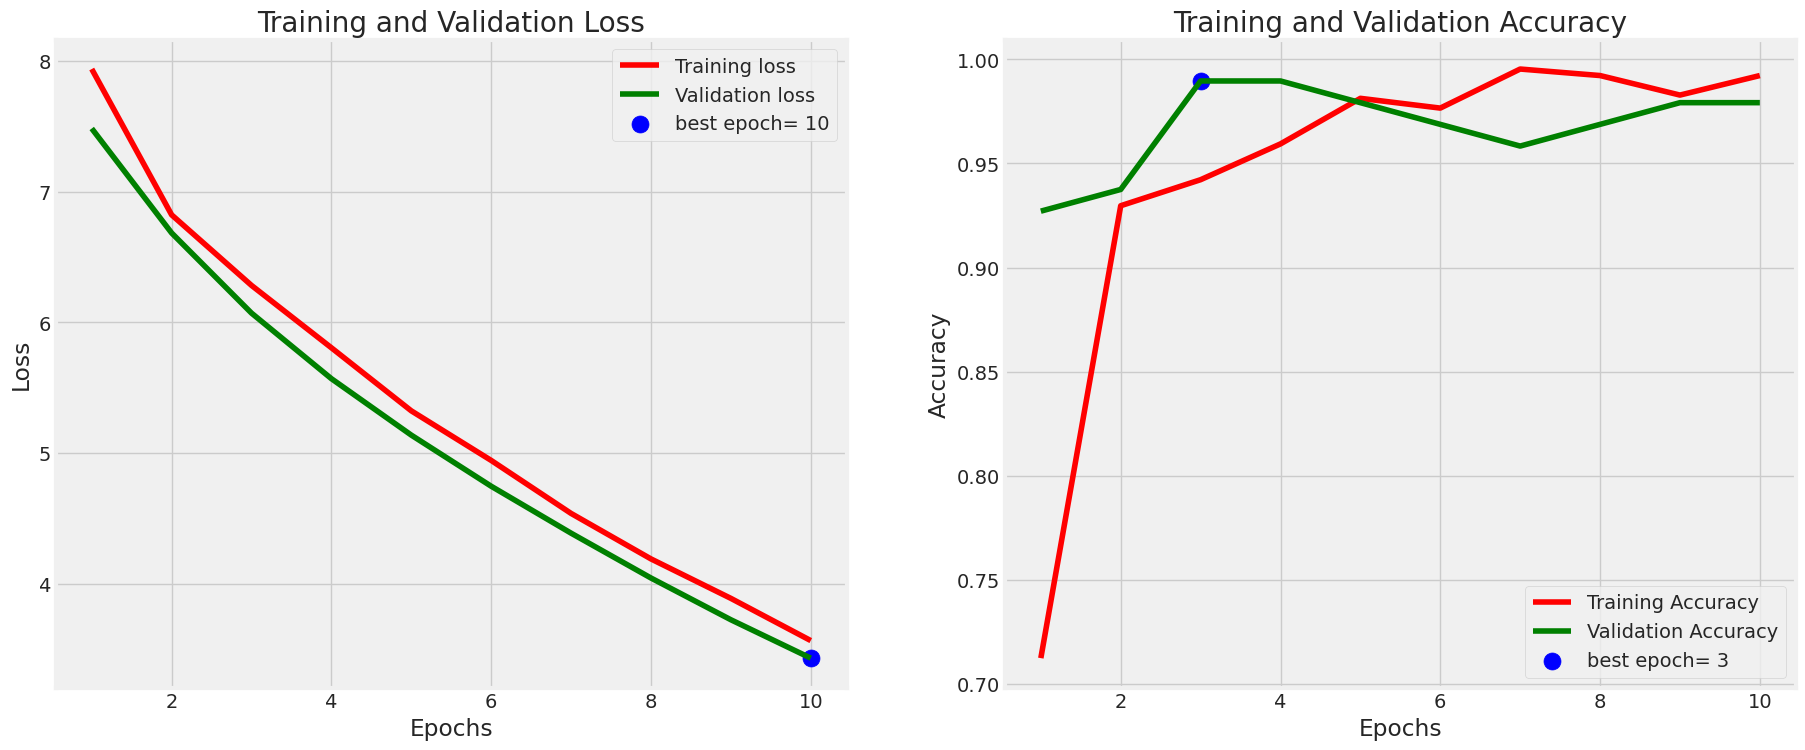

In [36]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [37]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

1/1 [==============================] - 0s 303ms/step - loss: 3.4710 - accuracy: 0.9531
Train Loss:  3.3412630558013916
Train Accuracy:  1.0
--------------------
Validation Loss:  3.3834519386291504
Validation Accuracy:  1.0
--------------------
Test Loss:  3.4710323810577393
Test Accuracy:  0.953125


In [38]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

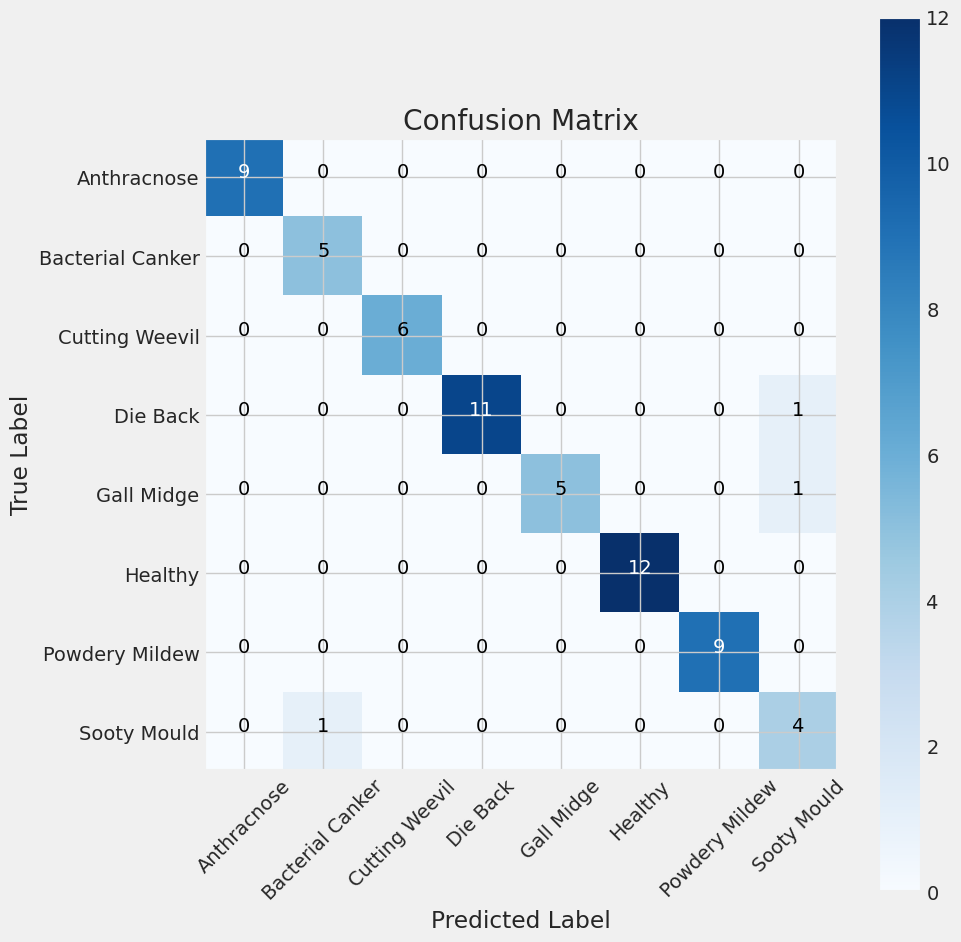

In [39]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

**NOTE** Previous cell contained RESTNET50.

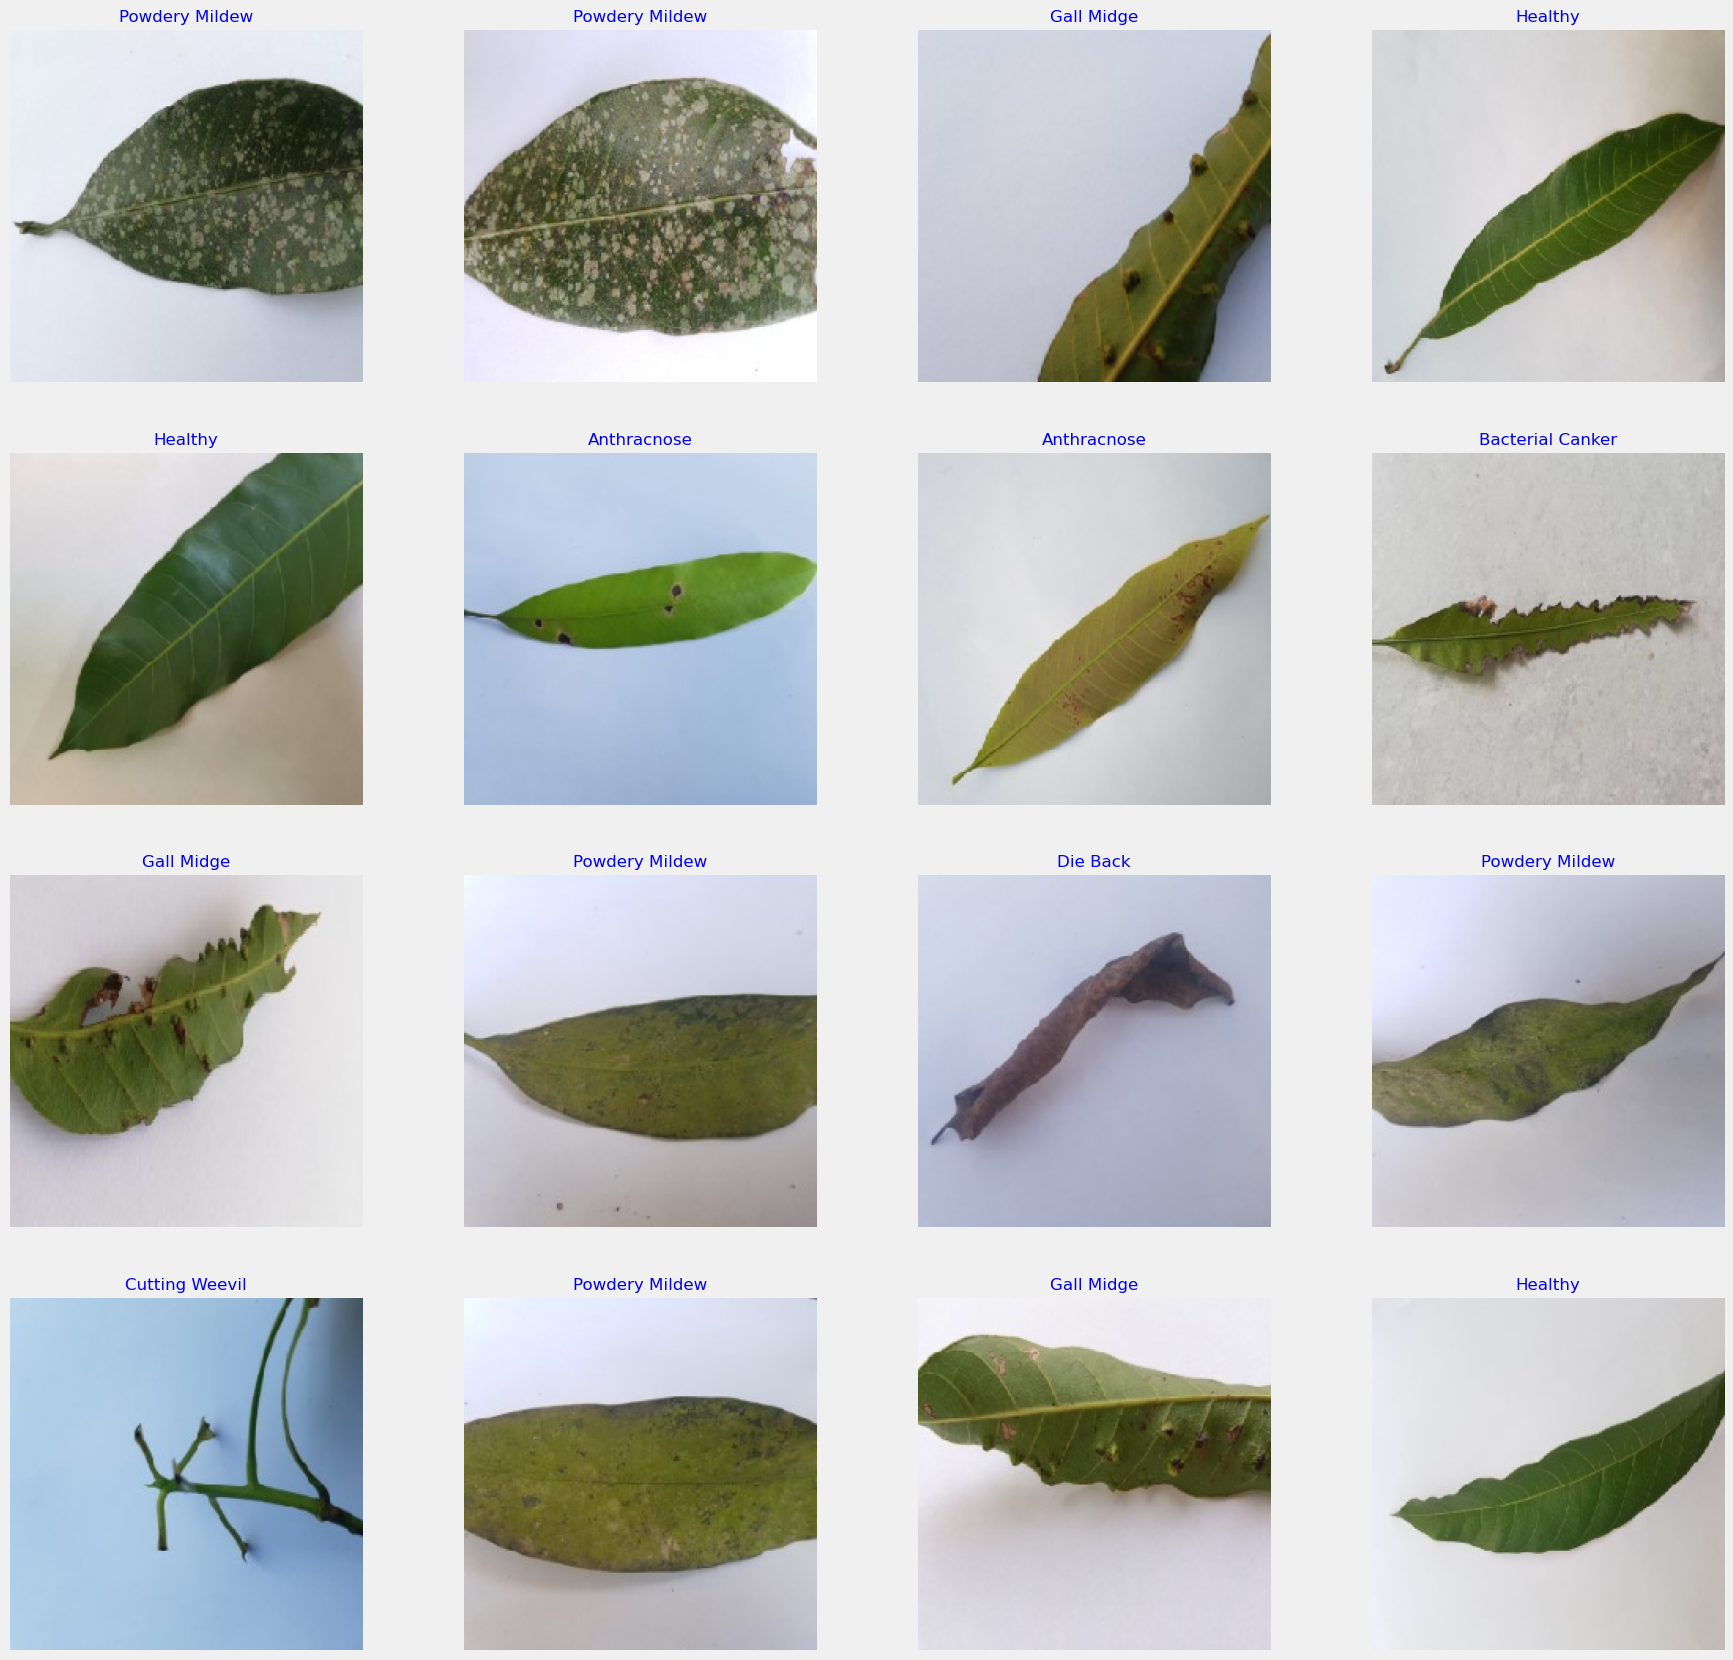

In [40]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

In [41]:
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use efficientnetb3 from EfficientNet family.
base_model = tf.keras.applications.VGG16(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)
base_model.trainable = False

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1000)              138357544 
                                                                 
 batch_normalization_4 (Batc  (None, 1000)             4000      
 hNormalization)                                                 
                                                                 
 dense_8 (Dense)             (None, 256)               256256    
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 8)                 2056      
                                                                 
Total params: 138,619,856
Trainable params: 260,312
Non-trainable params: 138,359,544
__________________________________

In [42]:
batch_size = 16   # set batch size for training
epochs = 10   # number of all epochs in training

history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, validation_steps= None, shuffle= False)

Epoch 1/10
40/40 [==============================] - 4s 54ms/step - loss: 5.7582 - accuracy: 0.3578 - val_loss: 4.1317 - val_accuracy: 0.5625
Epoch 2/10
40/40 [==============================] - 2s 48ms/step - loss: 3.2568 - accuracy: 0.6375 - val_loss: 3.1385 - val_accuracy: 0.6250
Epoch 3/10
40/40 [==============================] - 2s 47ms/step - loss: 2.5104 - accuracy: 0.6938 - val_loss: 2.7986 - val_accuracy: 0.6042
Epoch 4/10
40/40 [==============================] - 2s 46ms/step - loss: 2.1691 - accuracy: 0.7219 - val_loss: 2.6190 - val_accuracy: 0.5938
Epoch 5/10
40/40 [==============================] - 2s 46ms/step - loss: 1.9428 - accuracy: 0.7141 - val_loss: 2.4944 - val_accuracy: 0.5521
Epoch 6/10
40/40 [==============================] - 2s 46ms/step - loss: 1.7684 - accuracy: 0.7359 - val_loss: 2.3569 - val_accuracy: 0.6042
Epoch 7/10
40/40 [==============================] - 2s 48ms/step - loss: 1.6343 - accuracy: 0.7656 - val_loss: 2.2384 - val_accuracy: 0.6146
Epoch 8/10
40

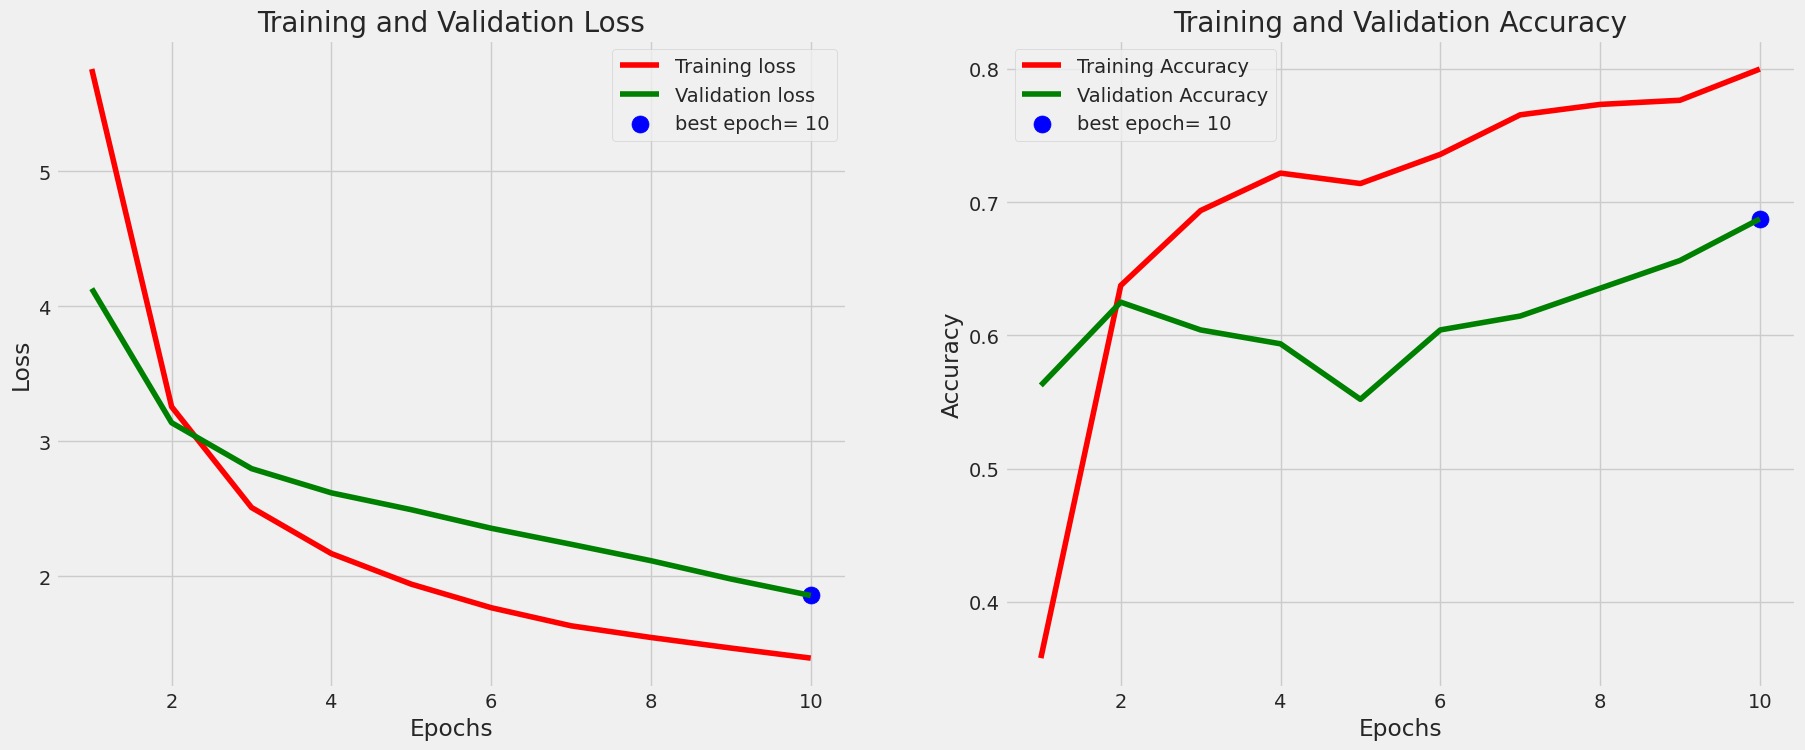

In [43]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [44]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

1/1 [==============================] - 0s 309ms/step - loss: 1.9477 - accuracy: 0.6562
Train Loss:  1.6033114194869995
Train Accuracy:  0.9375
--------------------
Validation Loss:  1.8064935207366943
Validation Accuracy:  0.625
--------------------
Test Loss:  1.947654128074646
Test Accuracy:  0.65625


In [45]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

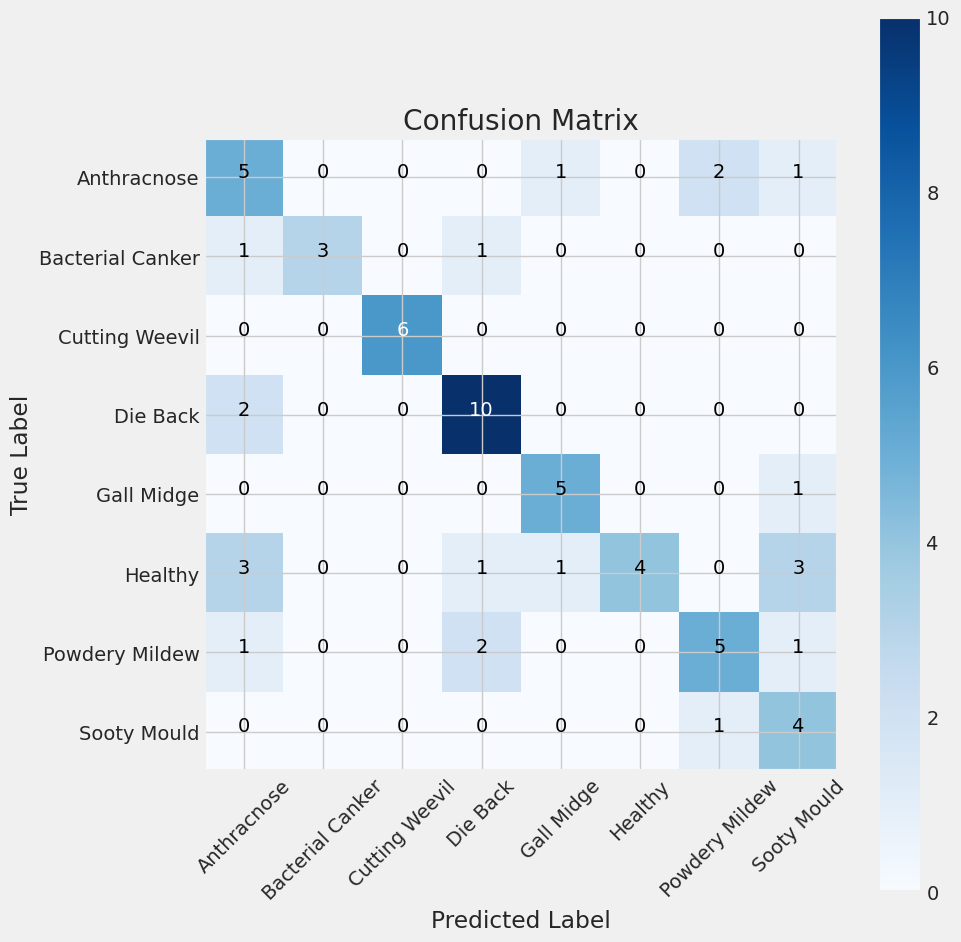

In [46]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

**NOTE** Previous cell contained VGG.